### MinMax scaling, L2 regularization 진행

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Input,BatchNormalization,Dropout, Conv2D, MaxPooling2D

df = pd.read_csv('./train.csv')

df_scaled = df
scale_cols = df_scaled[df_scaled.columns.difference(['leaktype'])].columns

scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled, columns=scale_cols)

df_scaled['leaktype'] = df['leaktype'].values 

feature_df = df_scaled[df_scaled.columns.difference(['leaktype'])]
label_df = df_scaled['leaktype']

label_df = label_df.replace('other', 0)
label_df = label_df.replace('noise', 1)
label_df = label_df.replace('normal', 2)
label_df = label_df.replace('in', 3)
label_df = label_df.replace('out', 4)

feature_np = feature_df.to_numpy().astype('float32')
label_np = label_df.to_numpy().astype('float32')

s = np.arange(len(feature_np))

np.random.shuffle(s)

feature_np = feature_np[s]
label_np = label_np[s]

split = 0.2

test_num = int(split*len(label_np))

x_test = feature_np[0:test_num]
y_test = label_np[0:test_num]

x_train = feature_np[test_num:]
y_train = label_np[test_num:]

#ont-hot encoding
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)

In [4]:
model = Sequential()

model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='elu', kernel_regularizer='l2'))
model.add(BatchNormalization())
#output layer number of class = 5
model.add(Dense(5, activation='softmax')) 

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), 
              loss='categorical_crossentropy', metrics=['accuracy', tfa.metrics.F1Score(5, average='macro')])

2022-07-08 10:35:16.624614: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-08 10:35:16.992128: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22314 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [5]:
from datetime import datetime

start_time = datetime.now()

hist = model.fit(x_train, y_train, epochs=200, validation_data = (x_test, y_test))

end_time = datetime.now()

print('\nElapsed Time => ', end_time - start_time)

2022-07-08 10:35:17.428744: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
 37/840 [>.............................] - ETA: 3s - loss: 2.0760 - accuracy: 0.5591 - f1_score: 0.3140 

2022-07-08 10:35:18.774631: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


840/840 [==============================] - 6s 5ms/step - loss: 1.1846 - accuracy: 0.6349 - f1_score: 0.3205 - val_loss: 1.1252 - val_accuracy: 0.6551 - val_f1_score: 0.2901
Epoch 2/200
840/840 [==============================] - 4s 5ms/step - loss: 1.0874 - accuracy: 0.6369 - f1_score: 0.2801 - val_loss: 0.9501 - val_accuracy: 0.6838 - val_f1_score: 0.3427
Epoch 3/200
840/840 [==============================] - 4s 5ms/step - loss: 1.0966 - accuracy: 0.6328 - f1_score: 0.2798 - val_loss: 0.9967 - val_accuracy: 0.6497 - val_f1_score: 0.2691
Epoch 4/200
840/840 [==============================] - 4s 5ms/step - loss: 1.1054 - accuracy: 0.6292 - f1_score: 0.2624 - val_loss: 1.0047 - val_accuracy: 0.6708 - val_f1_score: 0.2839
Epoch 5/200
840/840 [==============================] - 4s 5ms/step - loss: 1.0939 - accuracy: 0.6331 - f1_score: 0.2622 - val_loss: 1.0614 - val_accuracy: 0.6408 - val_f1_score: 0.2634
Epoch 6/200
840/840 [==============================] - 4s 5ms/step - loss: 1.0907 - acc

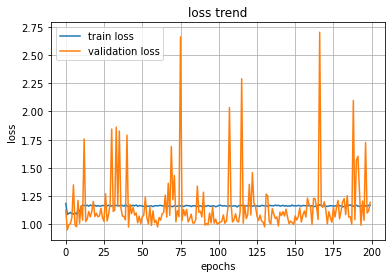

In [6]:
import matplotlib.pyplot as plt

plt.title('loss trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.show()

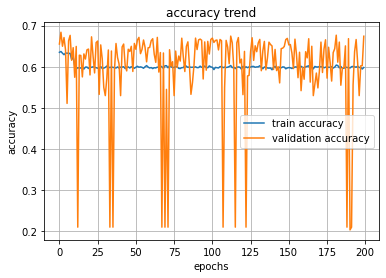

In [7]:
plt.title('accuracy trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')

plt.show()

### overfitting을 막으려고 dropout 비율을 높이고, 정규화를 진행하면 학습이 아예 진행이 안됨

### 데이터 분석 다시

In [24]:
import csv

df = pd.read_csv('./train.csv')

print(df.head())

  leaktype  0HZ  10HZ  20HZ  30HZ  40HZ  50HZ  60HZ  70HZ  80HZ  ...  5030HZ  \
0      out    0     2     2     0     2     0     2     2     2  ...       2   
1      out    0     0     0     3     0     3     0     0     0  ...       0   
2      out    0     4     4     4     4     5     4     4     5  ...       5   
3      out    0     6     5     5     6     5     6     6     5  ...       6   
4      out    0     3     0     0     3     0     0     3     3  ...       3   

   5040HZ  5050HZ  5060HZ  5070HZ  5080HZ  5090HZ  5100HZ  5110HZ  5120HZ  
0       5       2       2       5       2       2       5       2       5  
1       3       3       3       3       3       3       3       3       6  
2       5       6       5       6       6       6       5       6       4  
3       6       7       7       5       6       5       5       7       7  
4       3       3       3       3       3       3       3       3       3  

[5 rows x 514 columns]


In [25]:
type(df['leaktype'])

pandas.core.series.Series

In [30]:
df.groupby('leaktype').describe()

0HZ                                        10HZ            ...  \
            count mean  std  min  25%  50%  75%  max    count      mean  ...   
leaktype                                                                 ...   
in         1800.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   1800.0  6.830000  ...   
noise      5000.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   5000.0  4.497200  ...   
normal    18000.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  18000.0  4.260667  ...   
other      7000.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   7000.0  5.365857  ...   
out        1800.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   1800.0  5.893889  ...   

         5110HZ         5120HZ                                                  
            75%   max    count      mean        std  min  25%  50%   75%   max  
leaktype                                                                        
in         10.0  82.0   1800.0  9.080556  10.601250  0.0  3.0  5.0  10.0  69.0  
noise       6.0  74.0   5000.0  4.511400   3.904782  0.0  3.0  4.0   6.0  65.0  
normal      7.0  39.0  18000.0  6.317056   2.116050  2.0  5.0  6.0   7.0  37.0  
other       7.0  88.0   7000.0  7.682143   9.541584  0.0  3.0  5.0   7.0  81.0  
out         7.0  72.0   1800.0  6.637778   7.138035  0.0  3.0  5.0   7.0  71.0  

[5 rows x 4104 columns]

In [27]:
name = set(df['leaktype'])
print(name)

{'out', 'normal', 'noise', 'other', 'in'}


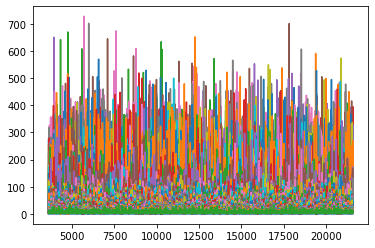

In [39]:
import matplotlib.pyplot as plt

plt.plot(df.groupby('leaktype').get_group('normal').iloc[:,1:])

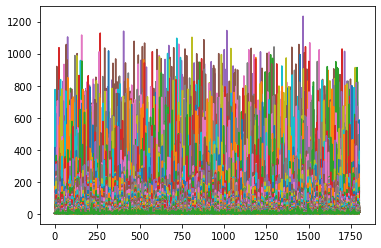

In [41]:
plt.plot(df.groupby('leaktype').get_group('out').iloc[:,1:])

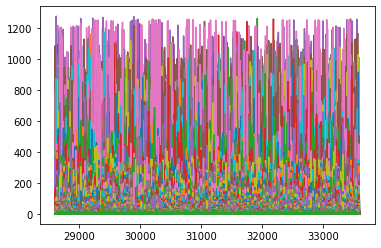

In [43]:
plt.plot(df.groupby('leaktype').get_group('noise').iloc[:,1:])

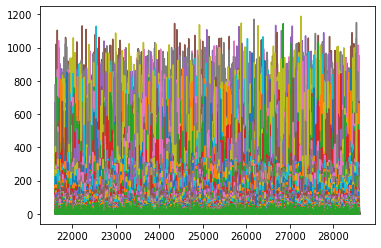

In [45]:
plt.plot(df.groupby('leaktype').get_group('other').iloc[:,1:])

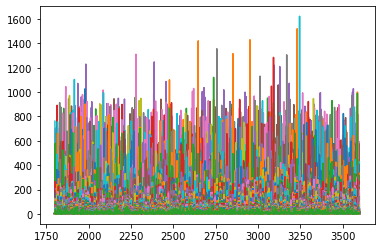

In [46]:
plt.plot(df.groupby('leaktype').get_group('in').iloc[:,1:])

In [38]:
df.groupby('leaktype').get_group('normal').iloc[0,1:].shape

(513,)

### Convolution layer로 학습 진행

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Input, BatchNormalization,Dropout, Conv1D, MaxPooling1D

df = pd.read_csv('./train.csv')

df_scaled = df
scale_cols = df_scaled[df_scaled.columns.difference(['leaktype'])].columns

scaler = StandardScaler()

df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled, columns=scale_cols)

df_scaled['leaktype'] = df['leaktype'].values 

feature_df = df_scaled[df_scaled.columns.difference(['leaktype'])]
label_df = df_scaled['leaktype']

label_df = label_df.replace('other', 0)
label_df = label_df.replace('noise', 1)
label_df = label_df.replace('normal', 2)
label_df = label_df.replace('in', 3)
label_df = label_df.replace('out', 4)

feature_np = feature_df.to_numpy().astype('float32')
label_np = label_df.to_numpy().astype('float32')

s = np.arange(len(feature_np))

np.random.shuffle(s)

feature_np = feature_np[s]
label_np = label_np[s]

split = 0.2

test_num = int(split*len(label_np))

x_test = feature_np[0:test_num]
y_test = label_np[0:test_num]

x_train = feature_np[test_num:]
y_train = label_np[test_num:]

#ont-hot encoding
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)

In [18]:
x_test.shape

(6720, 513, 1)

In [19]:
x_train.shape

(26880, 513, 1)

In [20]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)

In [21]:
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)

In [25]:
model = Sequential()

model.add(Conv1D(input_shape=(x_train.shape[1],1), kernel_size=32, filters=32, activation='relu', padding='same'))
model.add(Conv1D(kernel_size=32, filters=64, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=4, padding='same'))
model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax')) 

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), 
              loss='categorical_crossentropy', metrics=['accuracy', tfa.metrics.F1Score(5, average='macro')])

In [26]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 513, 32)           1056      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 513, 64)           65600     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 129, 64)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8256)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 8256)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               1056896   
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)              

In [27]:
from datetime import datetime

start_time = datetime.now()

hist = model.fit(x_train, y_train, epochs=300, validation_data = (x_test, y_test))

end_time = datetime.now()

print('\nElapsed Time => ', end_time - start_time)

Epoch 1/300
840/840 [==============================] - 7s 8ms/step - loss: 2.8343 - accuracy: 0.6614 - f1_score: 0.3457 - val_loss: 1.9083 - val_accuracy: 0.6775 - val_f1_score: 0.3042
Epoch 2/300
840/840 [==============================] - 7s 8ms/step - loss: 1.8661 - accuracy: 0.6765 - f1_score: 0.3501 - val_loss: 2.2014 - val_accuracy: 0.6707 - val_f1_score: 0.3344
Epoch 3/300
840/840 [==============================] - 7s 8ms/step - loss: 1.7265 - accuracy: 0.6807 - f1_score: 0.3508 - val_loss: 1.7482 - val_accuracy: 0.6969 - val_f1_score: 0.3209
Epoch 4/300
840/840 [==============================] - 7s 8ms/step - loss: 2.8345 - accuracy: 0.6765 - f1_score: 0.3433 - val_loss: 2.4323 - val_accuracy: 0.6897 - val_f1_score: 0.2987
Epoch 5/300
840/840 [==============================] - 7s 8ms/step - loss: 2.0119 - accuracy: 0.6810 - f1_score: 0.3512 - val_loss: 1.7561 - val_accuracy: 0.6900 - val_f1_score: 0.3218
Epoch 6/300
840/840 [==============================] - 7s 8ms/step - loss: 

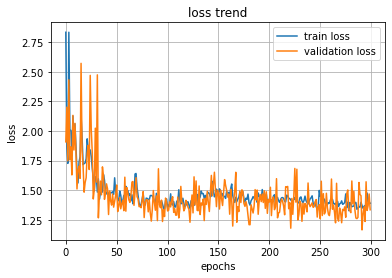

In [30]:
import matplotlib.pyplot as plt

plt.title('loss trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.show()

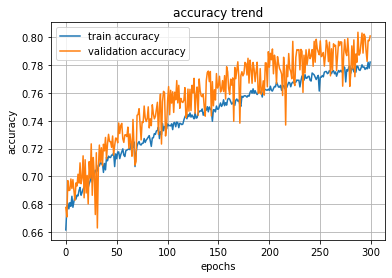

In [29]:
plt.title('accuracy trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')

plt.show()

### Dense layer에는 1차원을 input으로 줘야 하기 때문에 flatten을 해줘야 함
### 전체 데이터를 대상으로 convolution 연산을 진행하면 dense layer만으로 구성된 모델보다 학습이 안됨
### 액체 종류별로 데이터를 나눠 convolution 연산을 이용한 모델로 학습해야겠음